In [8]:
import fitsio
fits = fitsio.FITS("photoz.fits", iter_row_buffer=1000) 

#https://ui.adsabs.harvard.edu/abs/2019ApJS..242....8Z/abstract

type_col = 17
hlrdeV = 18
flrExp = 21
z_col = 29
mass_col = 47
sfr_col = 51



In [77]:
import math

def makeZLookup():
    H0km = 68
    ΩΛ = 0.7
    Ωm = 0.3
    
    data = []

    H0 = H0km / 3.08e19 * 60 * 60 * 24 * 365 * 1e6
    H = H0
    c = 1
    z = 0
    t = 0
    x1 = 0.1
    x2 = 0

    while t > -9000:
        t -= 1
        x1 += c - H * x1
        x2 += c - H * x2
        z = 0.1 / (x1 - x2) - 1
        H = H0 * (Ωm * (1+z)**3 + ΩΛ)**0.5

        if t % 100 == 0:
            data.append(z)
    
    return data

zlookup = makeZLookup()

def findZ(z):
    i = 0
    for n in zlookup:
        if n > z:
            return i
        i += 1
    return -1

In [31]:
def getBatch(start, length):
    colz = []
    colM = []

    M = 0
    z = 0
    
    for i in range(start, start + length):
        M = fits[1][i][mass_col]
        z = fits[1][i][z_col]
        if M > -99:
            colz.append(z)
            colM.append(M)
            
        
    return [colz, colM]


In [99]:
batch = getBatch(int(1e6), int(1e3))
len(batch[0])

996

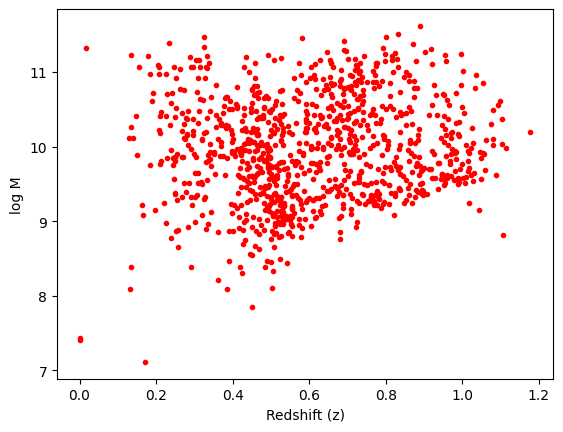

In [100]:
import matplotlib.pyplot as plt

A = -0.8
B = 1.4
datax = [0, 1, 1.2]
datay = [A, A + B, A + 1.2 * B] 

i = batch
plt.plot(i[0], i[1], 'r.', label = "desi_ls")

#plt.plot(datax, datay)
plt.xlabel("Redshift (z)")
plt.ylabel("log M")

plt.savefig('zmass.png',  bbox_inches='tight')
plt.show()

In [95]:
#import numpy as np
#colz = np.linspace(0,1.2,121)
#colM = np.linspace(7,12,501)

def getEmptyData():
    
    mainData = []

    for i in range((12 - 7) * 10 + 1):
        #z = 0 to 1.2
        mainData.append([0] * 90)

    return mainData


In [79]:
import math
M0 = 7

def getIMap(start, length, data):

    M = 0
    z = 0
    
    for i in range(start, start + length):
        M = fits[1][i][mass_col]
        z = fits[1][i][z_col]
        
        M = math.trunc((M - M0) * 10)
        z = math.trunc(z * 100)

        if M < 0:
            #print("skip low M", M)
            continue
        
        if M >= len(data):
            print("skip high M", M)
            continue

        if z < 0:
            print("skip low z", z)
            continue
        
        if z >= len(data[M]) :
            print("skip high z", z)
            continue
        
        
        data[M][z] += 1
            
    


In [126]:
import math
M0 = 7

def getIMapTime(start, length, data):

    M = 0
    z = 0
    i = 0
    
    #for i in range(start, start + length):
    for n in range(0, length):
        M = fits[1][n * 100 + start][mass_col]
        z = fits[1][n * 100 + start][z_col]
        
        M = math.trunc((M - M0) * 10)
        
        i = findZ(z)
        
        if M < 0:
            #print("skip low M", M)
            continue
        
        if M >= len(data):
            print("skip high M", M)
            continue

        if i < 0:
            print("skip l z", z)
            continue
        
        if i >= len(data[M]) :
            print("skip h z", z)
            continue
        
        
        data[M][i] += 1
            
    


In [133]:
data = getEmptyData()
imap = getIMapTime(int(2e8), int(1e6), data)

skip high M 54
skip high M 51
skip high M 51
skip high M 52
skip high M 51
skip high M 52
skip l z 1.6700794
skip high M 51
skip high M 51
skip high M 54
skip l z 1.3209064
skip high M 53
skip l z 1.673571
skip l z 1.6025885
skip high M 51
skip high M 52
skip l z 1.4913524
skip high M 51
skip high M 51


In [134]:
import math

datalog = []
for i in data:
    dlog = []
    for j in i:
        if j == 0:
            dlog.append(0)
        else:
            dlog.append(math.log10(j))
    datalog.append(dlog)

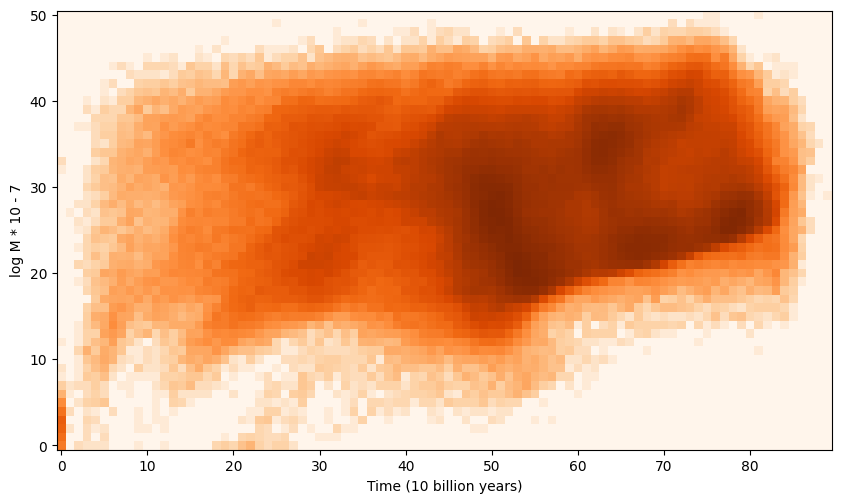

In [135]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))

im = plt.imshow(datalog, cmap='Oranges')

#cbar = plt.colorbar(im)

#plt.plot(datax, datay)
plt.xlabel("Time (10 billion years)")
plt.ylabel("log M * 10 - 7")
plt.gca().invert_yaxis()


#plt.savefig('tmass.png',  bbox_inches='tight')
plt.show()

In [45]:
f = open("zM", "a")

for i in range(len(batch[0])):
    try:
        f.write('{"z":' + str(round(batch[0][i], 4)) + ',"M":' + str(round(batch[1][i], 4)) + '},')
        
        
    except:
        print("skip")
    
f.close()